This cell was to check if we are connected to the internet

In [6]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on" )

We will now ensure that we are using the latest versions if the libraries

In [2]:
%pip install -Uqq fastai duckduckgo_search

^C
Note: you may need to restart the kernel to use updated packages.


%pip install -Uqq <libraries> upgrades to the latest version of <libraries>

Step 1: Download images of birds and non-birds

In [7]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [8]:
urls = search_images('bird pictures', max_images=1)
urls[0]

Searching for 'bird pictures'


'http://feedinspiration.com/wp-content/uploads/2015/04/Blue-Bird-Of-Paradise.jpg'

C:\Users\Sanskar\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


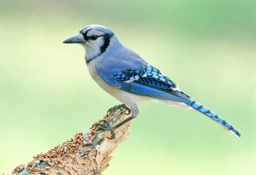

In [9]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


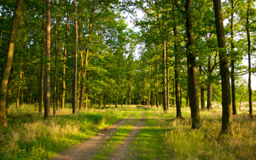

In [10]:
download_url(search_images('forest photos', max_images=2)[0], 'forest.jpg', show_progress=True)
Image.open('forest.jpg').to_thumb(256,256)

In [11]:
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


Step 2:Train our Model

We'll now use DataLoaders tha contains the training set and the validation set

In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


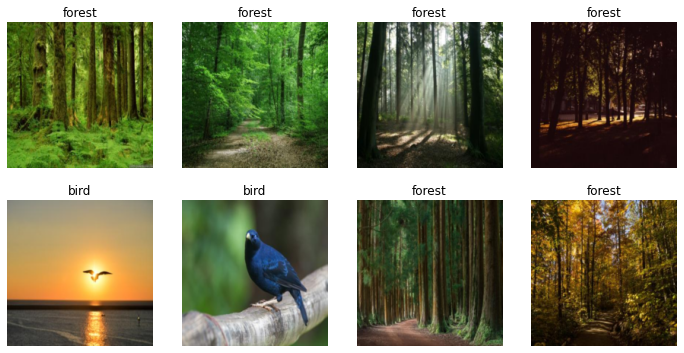

In [17]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),
The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files, 
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),
Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,
The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\Sanskar\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Sanskar\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sanskar/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 3.11MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.754248,0.043212,0.015152,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.041925,0.004921,0.000000,00:12
1,0.022459,0.016805,0.015152,00:12
2,0.014020,0.023229,0.015152,00:12


In [1]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f'This is a {is_bird}.')
print(f'Probability it is a bird: {probs[0]:.4f}')

NameError: name 'learn' is not defined